# Autoencoder Baseline

2026-01-27

Reproducing SKAB Vanilla AE results. Architecture: 8→5→4→2→4→5→8 with BatchNorm.
Anomaly detection via reconstruction error threshold.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

plt.rcParams['figure.figsize'] = (14, 4)

In [2]:
data_dir = Path('../data/raw/SKAB/data')

files = []
for folder in ['valve1', 'valve2', 'other']:
    files.extend(sorted((data_dir / folder).glob('*.csv')))

feature_cols = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
                'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

len(files)

34

In [3]:
def build_autoencoder(input_dim, params):
    inp = Input(shape=(input_dim,))
    x = Dense(params[0])(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(params[1])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    bottleneck = Dense(params[2], activation='linear')(x)
    x = Dense(params[1])(bottleneck)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(params[0])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    out = Dense(input_dim, activation='linear')(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(params[3]), loss='mae', metrics=['mse'])
    return model

# SKAB params: [encoder_l1, encoder_l2, bottleneck, lr, batch_size]
PARAMS = [5, 4, 2, 0.005, 32]
TRAIN_SIZE = 400
Q = 0.99

In [4]:
all_y_true = []
all_y_pred = []

for i, f in enumerate(files):
    df = pd.read_csv(f, sep=';', parse_dates=['datetime'], index_col='datetime')
    X = df[feature_cols]
    y = df['anomaly']

    X_train, X_test = X.iloc[:TRAIN_SIZE], X.iloc[TRAIN_SIZE:]
    y_test = y.iloc[TRAIN_SIZE:]

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)

    tf.random.set_seed(0)
    np.random.seed(0)
    model = build_autoencoder(len(feature_cols), PARAMS)
    model.fit(X_train_sc, X_train_sc, validation_split=0.2, epochs=40,
              batch_size=PARAMS[4], verbose=0, shuffle=True,
              callbacks=[EarlyStopping(patience=3, verbose=0)])

    # threshold from training residuals
    train_recon = model.predict(X_train_sc, verbose=0)
    residuals_train = pd.DataFrame(np.abs(X_train_sc - train_recon)).sum(axis=1)
    UCL = residuals_train.quantile(Q) * 5 / 2

    # predict
    test_recon = model.predict(X_test_sc, verbose=0)
    residuals_test = pd.DataFrame(np.abs(X_test_sc - test_recon)).sum(axis=1)
    pred = pd.Series((residuals_test > UCL).astype(int).values, index=X_test.index).fillna(0)

    all_y_true.append(y_test)
    all_y_pred.append(pred)

    if (i+1) % 10 == 0:
        print(f'{i+1}/{len(files)} files')

print('done')

10/34 files
20/34 files
30/34 files
done


In [5]:
y_true = pd.concat(all_y_true)
y_pred = pd.concat(all_y_pred)

f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
far = fp / (fp + tn) * 100
mar = fn / (fn + tp) * 100

print(f'F1:  {f1:.2f}  (SKAB: 0.39)')
print(f'FAR: {far:.2f}% (SKAB: 2.59%)')
print(f'MAR: {mar:.2f}% (SKAB: 75.15%)')

F1:  0.40  (SKAB: 0.39)
FAR: 2.65% (SKAB: 2.59%)
MAR: 74.72% (SKAB: 75.15%)


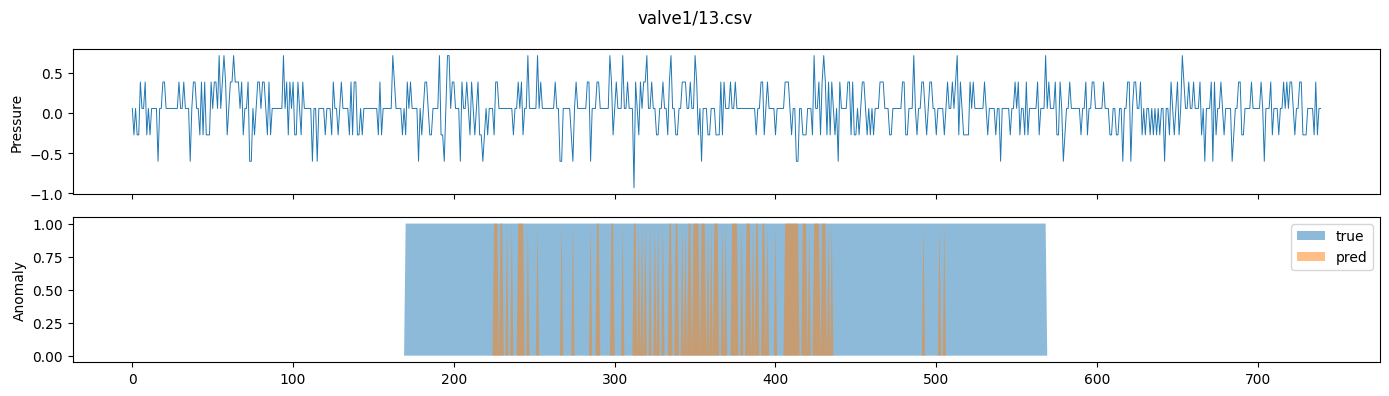

In [6]:
# visualize one file
idx = 5
sample = pd.read_csv(files[idx], sep=';', parse_dates=['datetime'], index_col='datetime')
X_s = sample[feature_cols]

sc = StandardScaler()
X_tr = sc.fit_transform(X_s.iloc[:TRAIN_SIZE])
X_te = sc.transform(X_s.iloc[TRAIN_SIZE:])

tf.random.set_seed(0)
np.random.seed(0)
m = build_autoencoder(8, PARAMS)
m.fit(X_tr, X_tr, validation_split=0.2, epochs=40, batch_size=32, verbose=0,
      callbacks=[EarlyStopping(patience=3, verbose=0)])

res_tr = pd.DataFrame(np.abs(X_tr - m.predict(X_tr, verbose=0))).sum(axis=1)
ucl = res_tr.quantile(Q) * 5 / 2

res_te = pd.DataFrame(np.abs(X_te - m.predict(X_te, verbose=0))).sum(axis=1)
viz_pred = (res_te > ucl).astype(int).values

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(sample['Pressure'].iloc[TRAIN_SIZE:].values, lw=0.7)
ax[0].set_ylabel('Pressure')

ax[1].fill_between(range(len(viz_pred)), sample['anomaly'].iloc[TRAIN_SIZE:].values, alpha=0.5, label='true')
ax[1].fill_between(range(len(viz_pred)), viz_pred, alpha=0.5, label='pred')
ax[1].legend()
ax[1].set_ylabel('Anomaly')
plt.suptitle(f'{files[idx].parent.name}/{files[idx].name}')
plt.tight_layout()

In [7]:
# model size
print(f'Model: {len(pickle.dumps(m))/1024:.0f} KB')
print(f'Scaler: {len(pickle.dumps(sc))/1024:.0f} KB')

Model: 79 KB
Scaler: 1 KB


In [8]:
# latency
m.predict(X_te[:1], verbose=0)  # warmup

single = X_te[:1]
times = []
for _ in range(1000):
    t0 = time.perf_counter()
    m.predict(single, verbose=0)
    times.append(time.perf_counter() - t0)

print(f'Single sample: {np.mean(times)*1000:.2f} ms avg, {np.median(times)*1000:.2f} ms median')

times_batch = []
for _ in range(100):
    t0 = time.perf_counter()
    m.predict(X_te, verbose=0)
    times_batch.append(time.perf_counter() - t0)

print(f'Full file ({len(X_te)} samples): {np.mean(times_batch)*1000:.2f} ms avg')

Single sample: 63.62 ms avg, 59.59 ms median
Full file (740 samples): 108.79 ms avg


---

Results close to SKAB leaderboard (minor differences from TF version).
Much smaller than IF (79 KB vs 1224 KB), but higher per-sample latency due to Keras overhead.
Next: Tiny LSTM.